### Library Imports

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas() 

### Data Loading from Hugging Face

In [3]:
dataset = load_dataset("stanfordnlp/imdb")

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

In [4]:
df_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tanutiwari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tanutiwari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tanutiwari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/tanutiwari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Data Preprocessing
Here are the steps we will take for data preprocessing:

* **Converting to Lower Case:** We will convert all the text in the comments to lowercase. This ensures uniformity and helps in accurate tokenization and analysis.

* **Removing URLs:** Any URLs present in the comments will be removed. URLs don't contribute to sentiment analysis and can be eliminated from the text.

* **Removing GIFs:** Similar to URLs, GIFs and other multimedia content will be removed from the comments as they don't carry textual sentiment information.

* **Removing Special Characters:** Special characters, punctuation marks, and symbols will be removed from the text. This simplifies the text and ensures that sentiment analysis focuses on words and their meanings.

* **Tokenization:** We will tokenize the preprocessed text, splitting it into individual words or tokens. This is a crucial step for further analysis.

* **Lemmatization:** Lemmatization involves reducing words to their base or root form. This helps in consolidating words with similar meanings and improves analysis accuracy.

In [6]:
def clean_text(text):
    text = text.lower()                                                             # Convert to lowercase
    text = re.sub(r'http\S+', '', text)                                             # Remove URLs
    text = re.sub(r'<.*?>', '', text)                                               # Remove HTML tags
    text = re.sub(r'\[.*?gif.*?\]', '', text, flags=re.IGNORECASE)                                                # Remove gif
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)                                        # Remove special characters
    tokens = word_tokenize(text)                                                    # Tokenization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]                        # Lemmatization
    cleaned_text = ' '.join(tokens)                                                 # Joining the tokens
    return cleaned_text

In [7]:
df_train['cleaned_text'] = df_train['text'].progress_apply(clean_text)  

100%|██████████| 25000/25000 [01:54<00:00, 218.85it/s]


In [18]:
df_test['cleaned_text'] = df_test['text'].progress_apply(clean_text)

100%|██████████| 25000/25000 [01:46<00:00, 234.77it/s]


In [9]:
df_train

,text,label,cleaned_text
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,i rented i am curious yellow from my video sto...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,i am curious yellow is a risible and pretentio...
2,If only to avoid making this type of film in t...,0,if only to avoid making this type of film in t...
3,This film was probably inspired by Godard's Ma...,0,this film wa probably inspired by godard s mas...
4,"Oh, brother...after hearing about this ridicul...",0,oh brother after hearing about this ridiculous...
...,...,...,...
24995,A hit at the time but now better categorised a...,1,a hit at the time but now better categorised a...
24996,I love this movie like no other. Another time ...,1,i love this movie like no other another time i...
24997,This film and it's sequel Barry Mckenzie holds...,1,this film and it s sequel barry mckenzie hold ...
24998,'The Adventures Of Barry McKenzie' started lif...,1,the adventure of barry mckenzie started life a...


### Vectorising Data using TF-IDF vectorizer

In [10]:
vectorizer = TfidfVectorizer()                              # sklearn tf-idf vectorizer
X_train = vectorizer.fit_transform(df_train['cleaned_text'])      # Creating vectors
y_train = df_train['label']                                       # Labels
X_test = vectorizer.transform(df_test['cleaned_text'])            # Creating vectors
y_test = df_test['label']                                         # Labels

In [11]:
X_train.shape, X_test.shape

((25000, 66541), (25000, 66541))

### Classical ML modeling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



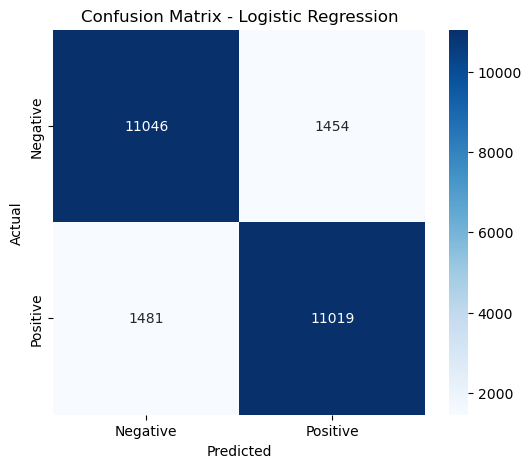

In [13]:
clf = LogisticRegression()  # Logistic Regression
clf.fit(X_train, y_train)  
y_pred_clf = clf.predict(X_test) 

print(classification_report(y_test, y_pred_clf))

cm = confusion_matrix(y_test, y_pred_clf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Random Forest

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



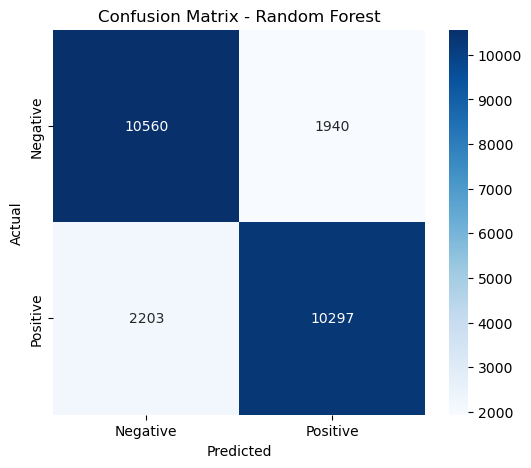

In [15]:
clf = RandomForestClassifier()  # Random Forest
clf.fit(X_train, y_train)  
y_pred_clf = clf.predict(X_test) 

print(classification_report(y_test, y_pred_clf))

cm = confusion_matrix(y_test, y_pred_clf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     12500
           1       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



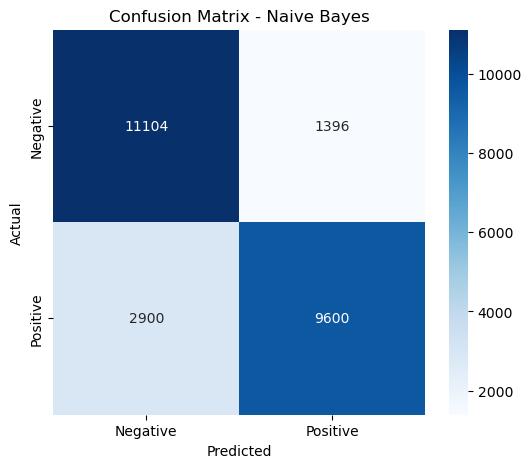

In [16]:
clf = MultinomialNB()  # Naive Bayes
clf.fit(X_train, y_train)  
y_pred_clf = clf.predict(X_test) 

print(classification_report(y_test, y_pred_clf))

cm = confusion_matrix(y_test, y_pred_clf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()